#DBScan

André Filipe

In [47]:
import kagglehub
import pandas as pd
import numpy as np

In [48]:
# Essa porção do código baixa diretamente a base de dados para o cache do usuário
# Download latest version
path = kagglehub.dataset_download("shivam2503/diamonds")

print("Path to dataset files:", path)
df = pd.read_csv(path+'/diamonds.csv')

Path to dataset files: C:\Users\filip\.cache\kagglehub\datasets\shivam2503\diamonds\versions\1


In [49]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [50]:
features_numericas = ['depth', 'table', 'price']
features_ordinais = ['color', 'cut', 'clarity']

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
encoder = OrdinalEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, features_numericas),
        ('ord', encoder, features_ordinais)
    ]
)



In [52]:
from sklearn.cluster import DBSCAN


dbscan_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dbscan', DBSCAN(eps=1.0, min_samples=5)) 
])



In [53]:
dbscan_pipeline.fit(df[['depth', 'table', 'price', 'color', 'cut', 'clarity']])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['depth', 'table', 'price']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['color', 'cut',
                                                   'clarity'])])),
                ('dbscan', DBSCAN(eps=1.0))])

In [54]:
labels = dbscan_pipeline.named_steps['dbscan'].labels_
df['cluster'] = labels

cluster
 1      30978
-1       2081
 27      1173
 30      1069
 6        892
        ...  
 209        5
 91         4
 193        4
 212        4
 225        3
Name: count, Length: 232, dtype: int64


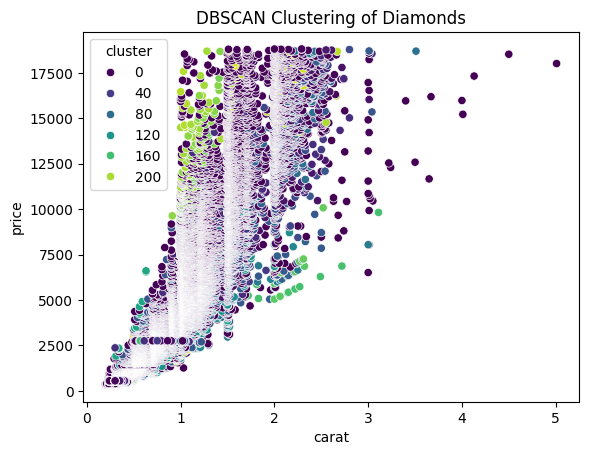

In [55]:
# Check unique clusters (-1 indicates noise)
print(df['cluster'].value_counts())

# Visualize the clusters (example: using carat and price)
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='carat', y='price', hue='cluster', palette='viridis')
plt.title('DBSCAN Clustering of Diamonds')
plt.show()

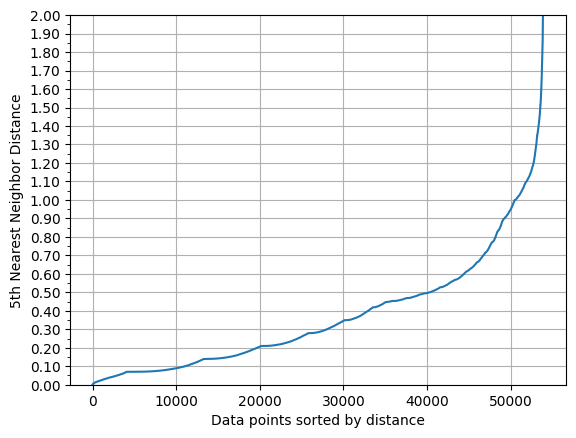

In [57]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.ticker as ticker

dados_transformados = preprocessor.fit_transform(df[['depth', 'table', 'price', 'color', 'cut', 'clarity']])

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(dados_transformados)
distancias, indices = neighbors_fit.kneighbors(dados_transformados)

# Plot the distances
distancias = np.sort(distancias[:, 4])  # Use the 5th nearest neighbor
plt.plot(distancias)
plt.xlabel('Data points sorted by distance')
plt.ylabel('5th Nearest Neighbor Distance')

# Focus y-axis on the range [0, 1]
plt.ylim(0, 2)

# Add more grid lines with custom ticks
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

plt.grid(True)
plt.show()

In [56]:
from sklearn.metrics import silhouette_score

print(silhouette_score(preprocessor.transform(df[['depth', 'table', 'price', 'color', 'cut', 'clarity']]), labels))

-0.28317445610839603


In [58]:
valores_eps = np.arange(0.1, 1.5, 0.1)  # Adjust the range and step size as needed
silhouette_scores = []

for eps in valores_eps:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(dados_transformados)

    # Compute silhouette score only if there are more than 1 cluster
    if len(set(labels)) > 1 and -1 not in set(labels):
        score = silhouette_score(dados_transformados, labels)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(-1)  # Assign -1 to invalid scores

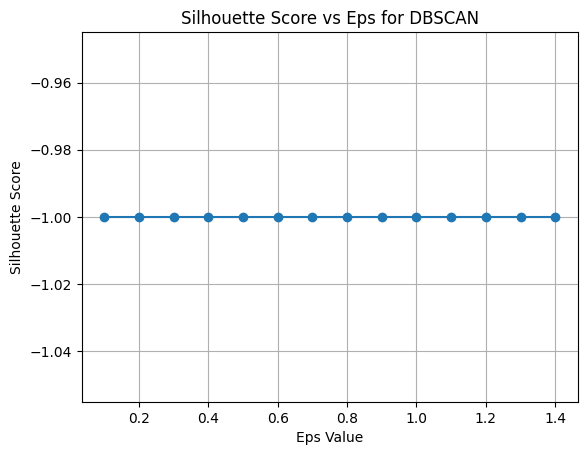

In [59]:
plt.plot(valores_eps, silhouette_scores, marker='o')
plt.xlabel('Eps Value')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Eps for DBSCAN')
plt.grid(True)
plt.show()

# Usando dados limpos

In [63]:
df_limpo = pd.read_csv('./data/cleaned.csv')

In [74]:
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan.fit(df_limpo)
df['cluster'] = dbscan.labels_
print(df['cluster'].value_counts())


cluster
-1      5210
 29      896
 27      724
 379     601
 459     505
        ... 
 596       4
 618       4
 676       4
 749       4
 758       4
Name: count, Length: 760, dtype: int64


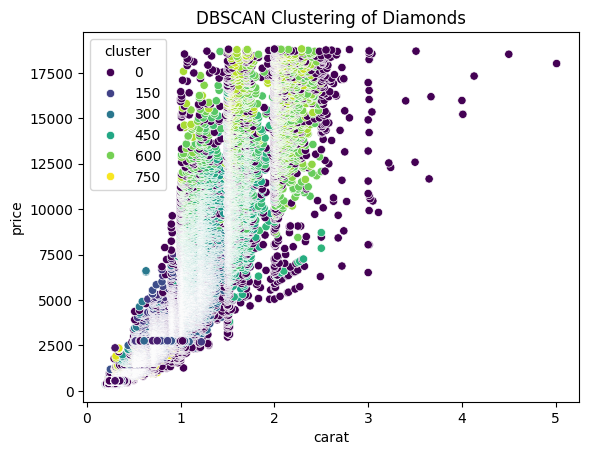

In [75]:
sns.scatterplot(data=df, x='carat', y='price', hue='cluster', palette='viridis')
plt.title('DBSCAN Clustering of Diamonds')
plt.show()